In [1]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# PARAMETERS

In [2]:
# csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'

batch_size = 32
# train_fraction = 0.8

hidden_size = 64
lr=0.001
num_epochs = 200

# DATASET

In [ ]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        super().__init__()
        data = pd.read_csv(csv_file)
        self.features = data.iloc[:, 1:]
        self.labels = data.iloc[:, 0]

        self.scaler = StandardScaler() # z-score all input features
        self.features = self.scaler.fit_transform(self.features)

        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

In [4]:
train_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_train.csv')
valid_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_valid.csv')
test_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_test.csv')

In [5]:
# train_size = int(train_fraction * len(dataset))
# remaining = len(dataset) - train_size
# test_size = int(np.ceil(remaining / 2))
# valid_size = int(np.floor(remaining / 2))

# train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# NETWORK

In [7]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

In [8]:
input_size = train_dataset.features.shape[1] 
output_size = len(set(train_dataset.labels))

In [9]:
model = SimpleNN(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# TRAIN FUNCTION

In [10]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        # correct_train = 0
        # total_train = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(features)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_train_loss += loss.item()

            # _, predicted = torch.max(outputs.data, 1)
            # total_train += labels.size(0)
            # correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0
        # correct_valid = 0
        # total_valid = 0
        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

                # _, predicted = torch.max(outputs.data, 1)
                # total_valid += labels.size(0)
                # correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)

        # epoch_train_accuracy = 100 * correct_train / total_train
        # epoch_valid_accuracy = 100 * correct_valid / total_valid

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
    
    # Return the lists of losses for further analysis or plotting
    return train_losses, valid_losses

# TEST FUNCTION

In [11]:
def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

# TRAIN

In [12]:
train_losses, valid_losses = train(model, train_loader, valid_loader, num_epochs, criterion, optimizer)

Epoch 1/200, Train Loss: 0.6613, Valid Loss: 0.6413
Epoch 2/200, Train Loss: 0.6300, Valid Loss: 0.6314
Epoch 3/200, Train Loss: 0.6078, Valid Loss: 0.6219
Epoch 4/200, Train Loss: 0.6111, Valid Loss: 0.6123
Epoch 5/200, Train Loss: 0.5731, Valid Loss: 0.5999
Epoch 6/200, Train Loss: 0.5820, Valid Loss: 0.5874
Epoch 7/200, Train Loss: 0.5567, Valid Loss: 0.5743
Epoch 8/200, Train Loss: 0.5395, Valid Loss: 0.5635
Epoch 9/200, Train Loss: 0.5276, Valid Loss: 0.5550
Epoch 10/200, Train Loss: 0.5150, Valid Loss: 0.5443
Epoch 11/200, Train Loss: 0.5199, Valid Loss: 0.5324
Epoch 12/200, Train Loss: 0.5067, Valid Loss: 0.5202
Epoch 13/200, Train Loss: 0.4898, Valid Loss: 0.5095
Epoch 14/200, Train Loss: 0.4782, Valid Loss: 0.4994
Epoch 15/200, Train Loss: 0.4616, Valid Loss: 0.4882
Epoch 16/200, Train Loss: 0.4436, Valid Loss: 0.4761
Epoch 17/200, Train Loss: 0.4480, Valid Loss: 0.4669
Epoch 18/200, Train Loss: 0.4311, Valid Loss: 0.4597
Epoch 19/200, Train Loss: 0.4151, Valid Loss: 0.4514
Ep

# LOSS CURVES

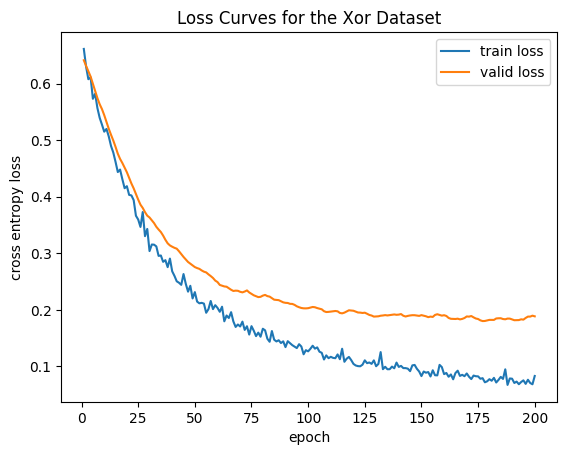

In [13]:
plt.plot(list(range(1, (num_epochs) + 1)), train_losses, label='train loss')
plt.plot(list(range(1, (num_epochs) + 1)), valid_losses, label='valid loss')
plt.title(f'Loss Curves for the {csv_file_prefix.capitalize()} Dataset')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.legend()

plt.show()

# TEST

In [14]:
test_accuracy = test(model, test_loader)

Test Accuracy: 91.0000


# DECISION BOUNDARY

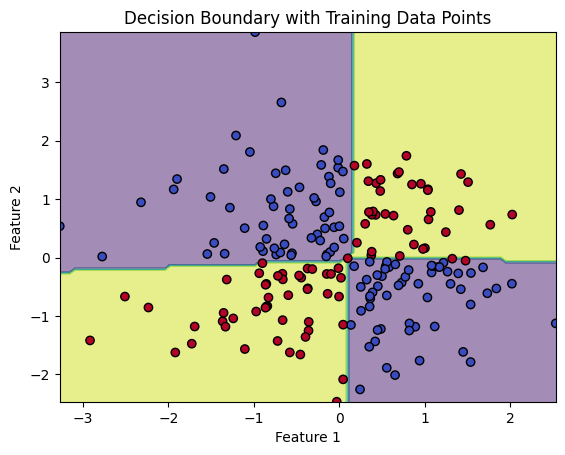

In [15]:
x_min, x_max = train_dataset.features[:, 0].min(), train_dataset.features[:, 0].max()
y_min, y_max = train_dataset.features[:, 1].min(), train_dataset.features[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_points) 
    Z = Z.argmax(dim=1).numpy()

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

for inputs, label in train_loader:
    inputs = inputs.numpy()
    label = label.numpy()
    plt.scatter(inputs[:, 0], inputs[:, 1], c=label, edgecolor='k', cmap='coolwarm', marker='o')

plt.title(f"Decision Boundary with Training Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()